## Preparing the Data
We use the 'Chemically Peculiar stars catalogue' in this code. The data was available in two parts. One was the catalogue of stars documenting the abundances various elements stored here in the file 'Abundances.csv' and the other being the effective temperature of each star in the catalogue in the file 'Temperature.csv'.

We link the two datasets and prepare the necessary variables to test the correlation of Helium abundance with the effective temperature of stars

In [164]:
import pandas as pd
import numpy as np
abund_df = pd.read_csv('Abundances.csv', na_values='-')
temp_df = pd.read_csv('Temperatures.csv')
df = pd.merge(abund_df, temp_df, on='Star_id')

In [165]:
# Selecting only those rows which have non-empty values for both abundance measure and error 

He_df = df[(df['ƐHe [2]'].notnull()) & (df['err_ƐHe'].notnull())]
He = np.array(He_df['ƐHe [2]']) # abundance measure
sig_He = np.array(He_df['err_ƐHe'])# error in abundance
Temp_He = np.array(He_df['T_eff'])# effective temperature of star

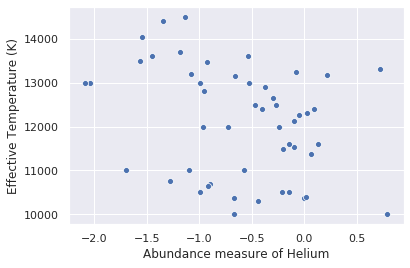

In [166]:
scatter = sns.scatterplot(He, Temp_He)
plt.xlabel('Abundance measure of Helium')
plt.ylabel('Effective Temperature (K)')
fig3 = scatter.get_figure()
fig3.savefig('Scatter.png')

Since we select only those stars which have non-empty values for both abundance measure and error, we are left with only 50 observations as compared to the available 85. And the further tests we perform are subject to this limitation.

In [167]:
# Running the standard spearman rank test


from scipy.stats import spearmanr as spr
rho, pval = spr(He, Temp_He)
print('Standard method gives correlation',rho)

Standard method gives correlation -0.3178771683561642


In [168]:
#Defining a function to generate bootstrap indices

def bootstrap_resample(X, n):
    # Here, n = no. of samples in the generated dataset
    
    resample_i = np.floor(np.random.rand(n)*len(X)).astype(int)
    return resample_i


#Defining a function to have perturbation in x
def perturb(x, sig_x):
    n= len(x)
    g= np.random.normal(0,1,n)
    x_p= np.zeros(n)
    x_p= x + g*sig_x    #making the perturbation to x
    return x_p

In [169]:
#Function to calculate correlation with bootstrapped samples

def MC_spearman(x, y, n):
    corr_samples = np.empty(shape=(1500, 1))
    for i in range(1500):  
        ind = bootstrap_resample(x, n)
        x_resample = x[ind];
        y_resample = y[ind];
        rho, pval = spr(x_resample, y_resample)
        corr_samples[i] = rho
    return corr_samples

In [170]:
#Function to calculate correlation with perturbed values of Helium concentration

def perturb_spearman(x, y, sig_x, n):
    corr_samples = np.empty(shape=(1500, 1))
    for i in range(1500):  
        ind = bootstrap_resample(x, n)
        x_resample = x[ind];
        sig_x_resample = sig_x[ind]
        x_resample = perturb(x_resample, sig_x_resample)
        y_resample = y[ind];
        rho, pval = spr(x_resample, y_resample)
        corr_samples[i] = rho
    return corr_samples

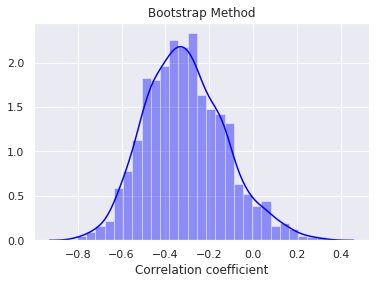

In [171]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
#Testing the Monte Carlo spearman test

He_correl_1 = MC_spearman(He, Temp_He, 30)
hist1 = sns.distplot(He_correl_1, norm_hist=False, color='blue')
plt.xlabel('Correlation coefficient')
plt.title('Bootstrap Method')
plt.show()


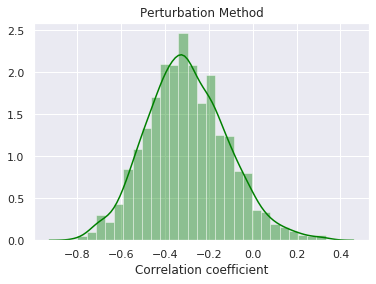

In [172]:
#Testing the Monte Carlo spearman test with perturbation

He_correl_2 = perturb_spearman(He, Temp_He, sig_He, 30)
hist2 = sns.distplot(He_correl_2, color='green')
plt.xlabel('Correlation coefficient')
plt.title('Perturbation Method')
plt.show()


In [149]:
corr1 = np.mean(He_correl_1)
std1 = np.std(He_correl_1)
corr2 = np.mean(He_correl_2)
std2 = np.std(He_correl_2)

In [150]:
print('Bootstrapping method gives mean correlation',corr1,'with standard deviation',std1)
print('Perturbation method gives mean correlation',corr2,'with standard deviation',std2)

Bootstrapping method gives mean correlation -0.31071568171772274 with standard deviation 0.18467497386811527
Perturbation method gives mean correlation -0.3034931229418346 with standard deviation 0.18146050264072555


In [153]:
fig1 = hist1.get_figure()
fig1.savefig('Perturb.png')
fig2 = hist2.get_figure()
fig2.savefig('Perturb.png')